# Read Data

In [43]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# for LR
import statsmodels.api as sm
from sklearn.model_selection import KFold
import random

# for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# for Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# for feature eng
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords

In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [9]:
%%time
train_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/train.csv')
test_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/test.csv')
print('Shape of test data is', test_data.shape)
print('Shape of train data is',train_data.shape)

<string>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Shape of test data is (804684, 12)
Shape of train data is (903653, 12)
CPU times: user 21.3 s, sys: 2 s, total: 23.3 s
Wall time: 23.7 s


# Data Cleaning

To do for data cleaning
- json to dataframe columns
- format various data types
- need to format the date field
- visitNumber as int
- format visitStartTime
- format visits
- format campaignCode
- deal with nulls
- drop columns that are not needed

### Convert json columns to df format

In [10]:
%%time
def json_to_lst(model_data, json_cols):
    for column in json_cols:
        model_data = model_data.join(pd.DataFrame(
            model_data.pop(column).apply(pd.io.json.loads).values.tolist(), index=model_data.index)) 
    
    return model_data

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [5]:
%%time
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
train_data_v1 = json_to_lst(train_data, json_cols)
test_data_v1 = json_to_lst(test_data, json_cols)

CPU times: user 1min 7s, sys: 9.96 s, total: 1min 17s
Wall time: 1min 17s


The 'adwordsClickInfo' feild is a dictionary. Let's change that to a dataframe columns.

In [6]:
%%time
concat_df = pd.DataFrame(train_data_v1['adwordsClickInfo'].tolist())
train_data_v2 = train_data_v1.drop(columns = ['adwordsClickInfo'])
train_data_v3 = pd.concat([train_data_v2,concat_df], axis=1)

CPU times: user 8.7 s, sys: 4.36 s, total: 13.1 s
Wall time: 13.6 s


### Drop Columns with No Data

In [7]:
print('Shape of train data version 3 is:', train_data_v3.shape)
train_data_v3.head(3)

Shape of train data version 3 is: (903653, 56)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,adNetworkType,criteriaParameters,gclId,isVideoAd,page,slot,targetingCriteria
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


Data is not available in several columns in the dataset. These columns will be dropped from the dataframe. 'visits' field will also be deleted as it has only one value in the column ('1').

In [8]:
train_data_v4 = train_data_v3.drop(columns = ['browserSize', 'browserVersion', 'flashVersion', 'language','mobileDeviceBranding', 
                             'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                              'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 'screenResolution',
                             'cityId', 'latitude', 'longitude', 'networkLocation', 'targetingCriteria', 
                                              'criteriaParameters', 'visits', 'socialEngagementType', 'isTrueDirect'])

print('Shape of train_data version 4 is:', train_data_v4.shape)

Shape of train_data version 4 is: (903653, 35)


### Adjusting Data Types

#### Proper Formating for Data Fields:
- date to datetime
- hits to int
- newVisits to int
- pageviews to int
- transactionRevenue to float64
- page to int
- bounces to int
- visitStartime to datetime

In [9]:
train_data_v4['date'] = pd.to_datetime(train_data_v4['date'], format='%Y%m%d')
train_data_v4['transactionRevenue'] = train_data_v4['transactionRevenue'].fillna(1).astype('float64')
train_data_v4['hits'] = train_data_v4['hits'].fillna(0).astype('int64')
train_data_v4['newVisits'] = train_data_v4['newVisits'].fillna(0).astype('int64')
train_data_v4['pageviews'] = train_data_v4['pageviews'].fillna(0).astype('int64')
train_data_v4['page'] = train_data_v4['page'].fillna(0).astype('int64')
train_data_v4['bounces'] = train_data_v4['bounces'].fillna(0).astype('int64')
train_data_v4['isVideoAd'] = train_data_v4['isVideoAd'].fillna('False').astype('bool')
train_data_v4['visitStartTime'] = train_data_v4['visitStartTime'].apply(lambda x: dt.datetime.utcfromtimestamp(float(x)))
train_data_v4['visitHour'] = train_data_v4['visitStartTime'].dt.hour

### Deal with Nulls

In [11]:
null_df = pd.DataFrame(train_data_v4.isnull().sum(), columns = ['count_null_rows'])
# null_df = null_df[null_df['count_null_rows']>0]
null_df = null_df[null_df['count_null_rows']>0].sort_values(by='count_null_rows', ascending=False)
null_df

,count_null_rows
campaignCode,903652
adContent,892707
adNetworkType,882193
slot,882193
gclId,882092
referralPath,572712
keyword,502929


fill all object column nans with '(not set)'

In [12]:
for i in train_data_v4.columns:
    if train_data_v4[i].isnull().sum() > 0:
        train_data_v4[i] = train_data_v4[i].fillna('(not set)')

Replace all 'not available in demo dataset' to '(not set)'

In [13]:
train_data_v4 = train_data_v4.replace(['not available in demo dataset', '(not set)'], ['(not_set)', '(not_set)'])

In [14]:
train_data_v4.isnull().sum().sum()

0

### Log Transaction Revenue

In [15]:
train_data_v4 = train_data_v4.assign(
    logtransactionRevenue = np.log(train_data_v4.transactionRevenue))
train_data_v4 = train_data_v4.drop(columns=['transactionRevenue'])

### Make Binary Made Purchase Columns

In [16]:
train_data_v4['madePurchase'] = np.where(train_data_v4['logtransactionRevenue'] > 0, 1, 0)

### Understanding the Unique Identifier

In [17]:
train_data_v4.head()
print('shape of train data version 4:', train_data_v4.shape[0])
print('number of unique session_ids is:', train_data_v4.sessionId.nunique())
print('diff is:', train_data_v4.shape[0]-train_data_v4.sessionId.nunique())
print('The sessionId should be a unique identifier. Investigate duplicates:')

shape of train data version 4: 903653
number of unique session_ids is: 902755
diff is: 898
The sessionId should be a unique identifier. Investigate duplicates:


The max count of duplicate sessionId is 2. This method does the following: 
    - if train data
        - Delete first of two duplicate rows as long as the first row does not have a transaction revenue > 0
    - if test_data
        - delete the first row of duplicate sessionId
Only 1 row in the train_data has a transacton revenue > 0 removed and thats because bith duplicate sessions had a revenue

In [11]:
def remove_session_id_dup(data, is_train):
    sessionId_counts = pd.DataFrame(data['sessionId'].value_counts()).reset_index()
    dup_sessionId = sessionId_counts['index'][sessionId_counts['sessionId']>1].values.tolist()
    dup_data = data[data['sessionId'].isin(dup_sessionId)].sort_values(by='sessionId')
    
    index_to_delete = []
    count = 0
    delete = False
    for index, row in dup_data.iterrows():
        if is_train:
            if count == 0 and row['madePurchase'] == 1: #leaves the first duplicate if the person has made a purchase
                count +=1
                delete = False
                continue
            elif count == 0 and delete == False: #deletes the first duplicate if person hasnt made a purchase
                index_to_delete.append(index)
                delete = True
                count +=1
            elif count == 1 and delete == False: #deletes the second duplicate if person has made a purchas in the first row
                index_to_delete.append(index)
                count = 0
            elif count == 1 and delete == True: #assign delete to false and continues
                delete = False
                count = 0
                continue
        elif count == 0 and delete == False:
            index_to_delete.append(index)
            delete = True
            count +=1
        else:
            delete = False
            count = 0
            
    data = data.reset_index()
    print('Deleted', len(index_to_delete), 'rows!')
    print('Shape of data before deleting duplicates:', data.shape)
    data_v1 = data[~data['index'].isin(index_to_delete)]
    print('Shape of data after deleting duplicates:', data_v1.shape)   

    return index_to_delete, data_v1

In [19]:
train_index_delete, train_data_v5 = remove_session_id_dup(train_data_v4, True)
test_index_delete, test_data_v1 = remove_session_id_dup(test_data, False)

Deleted 898 rows!
Shape of data before deleting duplicates: (903653, 38)
Shape of data after deleting duplicates: (902755, 38)
Deleted 821 rows!
Shape of data before deleting duplicates: (804684, 12)
Shape of data after deleting duplicates: (803863, 12)


# Feature Engineering

### Make Day, Month and Year Columns from Date

In [20]:
train_data_v5['dayNameDate'] = train_data_v5['date'].dt.day_name()
train_data_v5['monthDate'] = train_data_v5['date'].dt.month
train_data_v5['yearDate'] = train_data_v5['date'].dt.year
train_data_v5['dayDate'] = train_data_v5['date'].dt.day

In [21]:
train_data_v5.head()

,index,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,campaign,campaignCode,keyword,medium,referralPath,source,adNetworkType,gclId,isVideoAd,page,slot,visitHour,logtransactionRevenue,madePurchase,dayNameDate,monthDate,yearDate,dayDate
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not_set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),15,0.0,0,Friday,9,2016,2
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,Macintosh,(not_set),Oceania,Australia,(not_set),dodo.net.au,(not_set),Australasia,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),5,0.0,0,Friday,9,2016,2
2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not_set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),1,0.0,0,Friday,9,2016,2
3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,False,Linux,(not_set),Asia,Indonesia,(not_set),unknown.unknown,(not_set),Southeast Asia,1,1,1,1,(not_set),(not_set),(not_set),google + online,organic,(not_set),google,(not_set),(not_set),True,0,(not_set),5,0.0,0,Friday,9,2016,2
4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,Android,(not_set),Europe,United Kingdom,(not_set),unknown.unknown,(not_set),Northern Europe,1,1,0,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),13,0.0,0,Friday,9,2016,2


# EDA

### EDA Methods

In [22]:
def plot_hist(x, bins, xlabel, ylabel, title):
#     plt.style.use('ggplot')
    plt.style.use('seaborn')
    plt.hist(x, bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [23]:
def plot_scatter(x, y,xlabel, ylabel, title):
    plt.style.use('seaborn')
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [24]:
def plot_sns_scatter(data, x, y, hue):
    sns.lmplot(x=x, y=y, data=data, 
               fit_reg=False, legend=False, hue = hue)

In [25]:
def plot_cat_bar(data, col, title):
    plt.style.use('seaborn')
    col_value_counts = pd.DataFrame(data[col].value_counts())
    if col_value_counts.shape[0] > 10:
        col_value_counts = col_value_counts[:10]
    plt.bar(col_value_counts.index, col_value_counts[col])
    plt.title(title)
    plt.show()

## Analysis on Record Level

### Analysis on how many records made a purchase

In [26]:
col_value_counts = pd.DataFrame(train_data_v5['madePurchase'].value_counts())
print('Percentage of records that made a transaction:', 
      round(train_data_v5[train_data_v5['madePurchase'] ==1].shape[0]/train_data_v5.shape[0], 2))
col_value_counts

Percentage of records that made a transaction: 0.01


,madePurchase
0,891241
1,11514


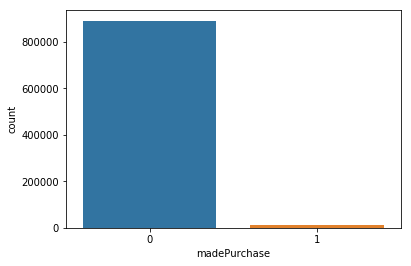

In [27]:
sns.countplot(x=train_data_v5['madePurchase'])

In [28]:
train_data_v5.groupby('madePurchase').mean()

,index,visitId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,monthDate,yearDate,dayDate
madePurchase,,,,,,,,,,,,,,,
0,451819.839018,1.484995e+09,2.241567,0.266898,0.505336,4.182548,0.783145,3.529667,0.976468,0.023728,12.514323,0.000000,6.988910,2016.516582,15.698008
1,451541.406288,1.485877e+09,4.083464,0.088588,0.000000,36.272190,0.387702,28.329686,0.960570,0.039430,14.127844,17.823269,6.907243,2016.551589,15.637832


You can tell clearly from above that the records that made a purchase are ones that have high pageviews, hits, 0 bounces and often not from a mobile device. The transactions are generally later in the day as well

In [29]:
train_data_v5.groupby('deviceCategory').mean()
# a major proportion of the logtransactionrevenue is from desktop.

,index,visitId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate
deviceCategory,,,,,,,,,,,,,,,,
desktop,446708.675887,1.484224e+09,2.474809,0.000164,0.492439,4.767454,0.772774,3.973249,0.983306,0.016801,12.637447,0.282774,0.015809,7.211906,2016.473539,15.687741
mobile,466037.038896,1.487262e+09,1.685839,0.999300,0.519791,4.013734,0.792797,3.416981,0.958610,0.041773,12.245312,0.069953,0.004086,6.345039,2016.642171,15.728543
tablet,465793.173589,1.486612e+09,1.658347,0.999540,0.496399,4.722272,0.793627,4.009437,0.943639,0.057117,12.282299,0.096034,0.005524,6.505475,2016.608201,15.689948


In [30]:
train_data_v4.groupby('channelGrouping').mean()

,visitId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,madePurchase
channelGrouping,,,,,,,,,,,,
(Other),1.491120e+09,4.458333,0.316667,0.466667,4.400000,0.208333,3.683333,1.000000,0.000000,13.925000,0.134309,0.008333
Affiliates,1.485954e+09,1.659331,0.095897,0.530452,3.405475,0.762543,2.890752,1.000000,0.000000,11.718527,0.009405,0.000549
Direct,1.486332e+09,2.793961,0.383860,0.495588,4.928614,0.747025,4.089047,1.000000,0.000000,12.849167,0.257472,0.014277
Display,1.485325e+09,8.793996,0.271479,0.358671,6.667199,0.299744,5.461833,1.000000,0.000000,14.450814,0.417089,0.022676
Organic Search,1.486731e+09,2.175736,0.355778,0.483199,4.928795,0.793142,4.112627,1.000000,0.000000,12.480544,0.158370,0.009010
Paid Search,1.486243e+09,3.406578,0.499724,0.380123,6.499961,0.622364,5.372345,0.152649,0.854221,12.206586,0.325533,0.018479
Referral,1.485918e+09,3.293214,0.054293,0.259820,8.340516,0.509023,6.749432,1.000000,0.000000,13.772172,0.907610,0.050659
Social,1.480620e+09,1.338006,0.118571,0.652357,1.905916,0.928931,1.763202,1.000000,0.000000,11.873442,0.007979,0.000460


In [31]:
train_data_v4.groupby('continent').mean()

,visitId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,madePurchase
continent,,,,,,,,,,,,
(not_set),1.482718e+09,1.288147,0.280654,0.603542,3.087875,0.904632,2.672343,0.991144,0.008856,11.779973,0.074423,0.004087
Africa,1.483496e+09,1.198915,0.350899,0.650390,2.449373,0.910953,2.157409,0.998169,0.001831,13.475144,0.010731,0.000543
Americas,1.485470e+09,3.036612,0.281560,0.386976,6.287433,0.695249,5.168608,0.953839,0.046541,13.247288,0.446452,0.025052
Asia,1.483563e+09,1.485060,0.217020,0.602960,2.834299,0.873723,2.470004,0.998167,0.001846,10.184642,0.010053,0.000559
Europe,1.485600e+09,1.547942,0.267766,0.618695,2.970632,0.841678,2.590890,0.999097,0.000903,13.751310,0.007033,0.000398
Oceania,1.486524e+09,1.349342,0.337518,0.550950,3.864421,0.851069,3.226584,0.997276,0.002724,8.930185,0.016837,0.000930


In [32]:
cross_tab_df = pd.crosstab(train_data_v5.deviceCategory, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
deviceCategory,,
desktop,653320,10494
mobile,207678,852
tablet,30243,168


In [33]:
cross_tab_df = pd.crosstab(train_data_v5.operatingSystem, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
operatingSystem,,
(not_set),4690,0
Android,123306,467
BlackBerry,218,0
Chrome OS,25314,994
Firefox OS,89,0
FreeBSD,9,0
Linux,34229,782
Macintosh,247260,6426
NTT DoCoMo,1,0


In [34]:
cross_tab_df = pd.crosstab(train_data_v5.isMobile, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
isMobile,,
False,653371,10494
True,237870,1020


In [35]:
cross_tab_df = pd.crosstab(train_data_v5.browser, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
browser,,
(not_set),8,0
0,7,0
ADM,1,0
Amazon Silk,560,1
Android Browser,552,0
Android Runtime,2,0
Android Webview,7849,6
Apple-iPhone7C2,9,0
BlackBerry,184,0


In [36]:
cross_tab_df = pd.crosstab(train_data_v5.continent, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
continent,,
(not_set),1461,6
Africa,14724,8
Americas,438714,11282
Asia,223220,125
Europe,198096,79
Oceania,15026,14


In [37]:
cross_tab_df = pd.crosstab(train_data_v5.metro, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
metro,,
(not_set),704437,4847
Abilene-Sweetwater TX,10,0
Albany-Schenectady-Troy NY,19,0
Atlanta GA,2363,99
Augusta GA,7,0
Austin TX,3575,210
Baltimore MD,31,1
Boise ID,3,0
Boston MA-Manchester NH,2492,136


In [38]:
cross_tab_df = pd.crosstab(train_data_v5.monthDate, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
monthDate,,
1,63934,697
2,61442,708
3,68978,883
4,66140,928
5,64160,1115
6,62556,946
7,70677,1031
8,76069,1161
9,70087,859


In [39]:
cross_tab_df = pd.crosstab(train_data_v5.dayDate, train_data_v5.madePurchase)
cross_tab_df

madePurchase,0,1
dayDate,,
1,31874,407
2,28600,332
3,29015,321
4,30603,312
5,30947,421
6,28971,368
7,28451,373
8,28723,365
9,28620,408


In [40]:
col_value_counts = pd.DataFrame(train_data_v5['networkDomain'].value_counts())
# print('Percentage of records that made a transaction:', 
#       round(train_data_v5[train_data_v5['madePurchase'] ==1].shape[0]/train_data_v5.shape[0], 2))
col_value_counts[:10]

,networkDomain
(not_set),244645
unknown.unknown,145890
comcast.net,28688
rr.com,14802
verizon.net,13630
ttnet.com.tr,13224
comcastbusiness.net,9975
hinet.net,7903
virginm.net,6411
3bb.co.th,6042


channelGrouping


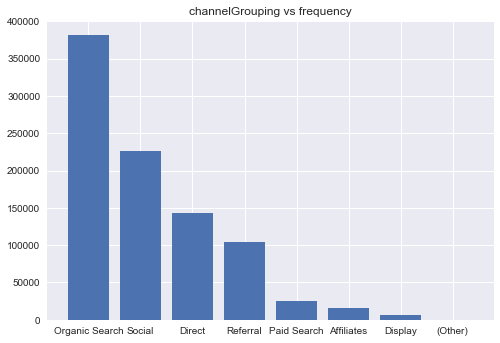

deviceCategory


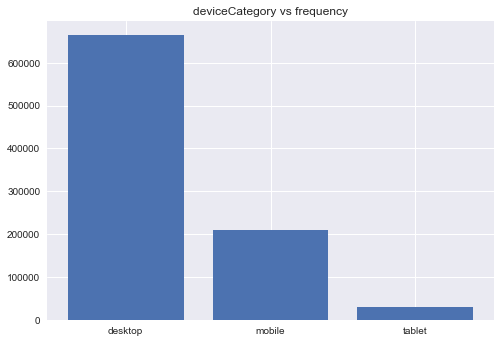

operatingSystem


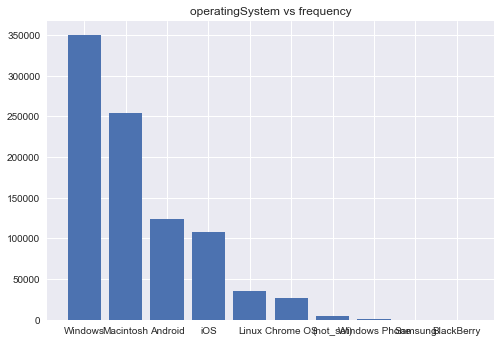

continent


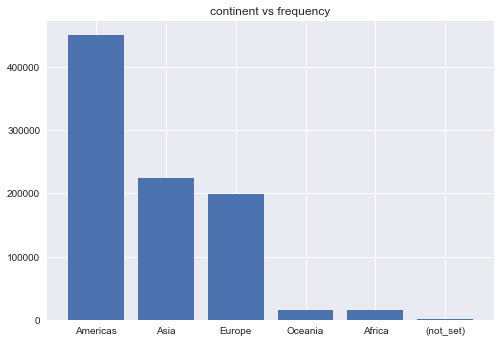

subContinent


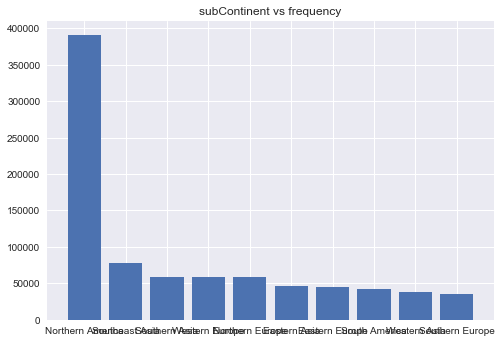

adContent


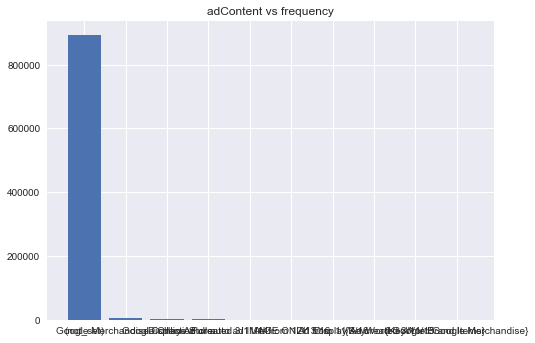

campaign


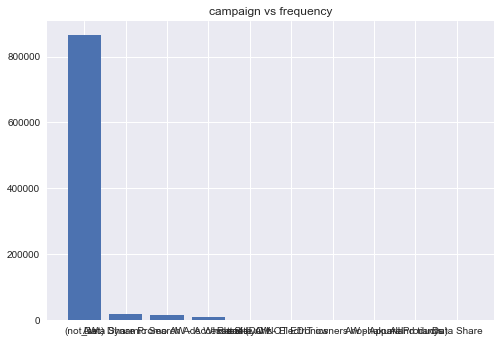

campaignCode


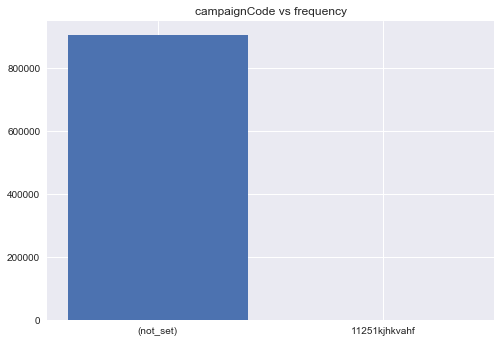

medium


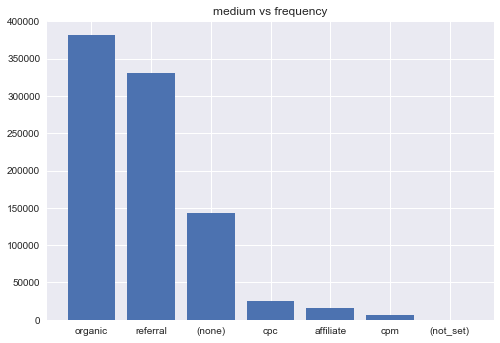

adNetworkType


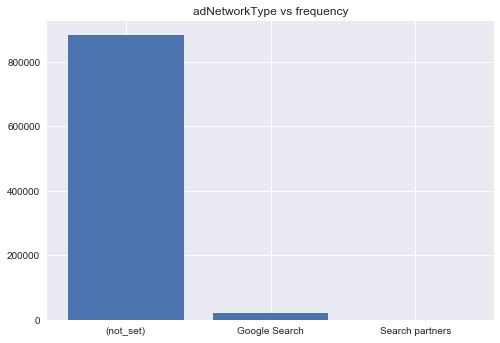

slot


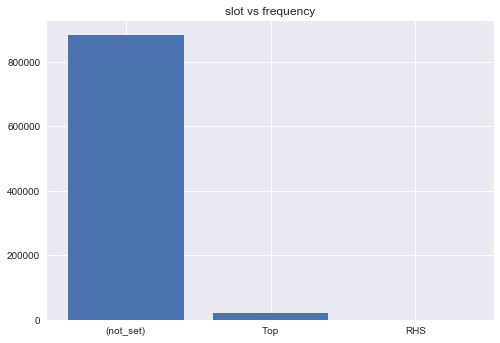

In [41]:
object_cols = train_data_v4.select_dtypes(include='object').columns
for i in object_cols:
    if i != 'fullVisitorId' and i != 'sessionId':
        if train_data_v4[i].nunique() <= 50:
            print(i)
            plot_cat_bar(train_data_v4, i, str(i) + ' vs frequency')
# plt.bar(test.index, test.channelGrouping)

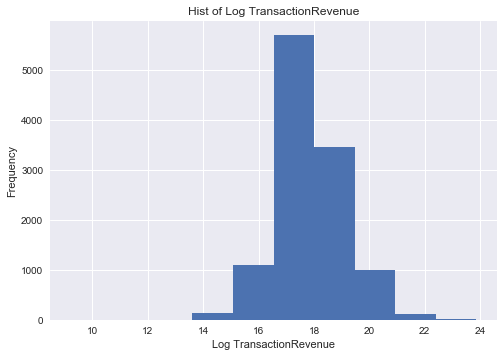

In [42]:
plot_hist(train_data_v5['logtransactionRevenue'][train_data_v5['logtransactionRevenue'] > 0], 10, 
          'Log TransactionRevenue', 'Frequency', 'Hist of Log TransactionRevenue')

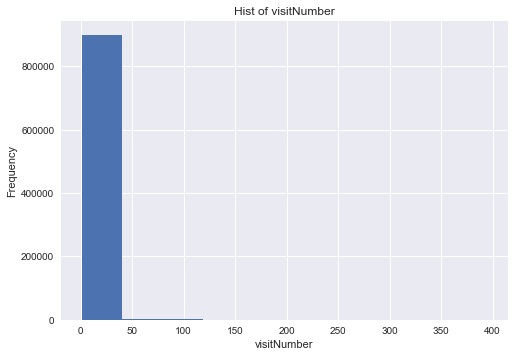

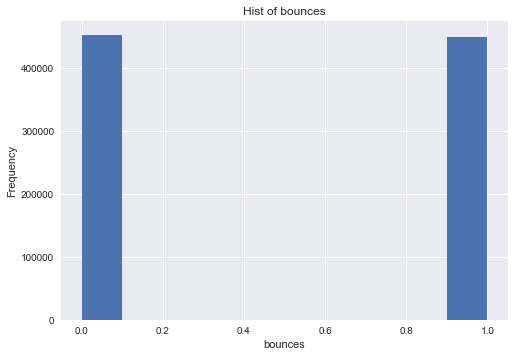

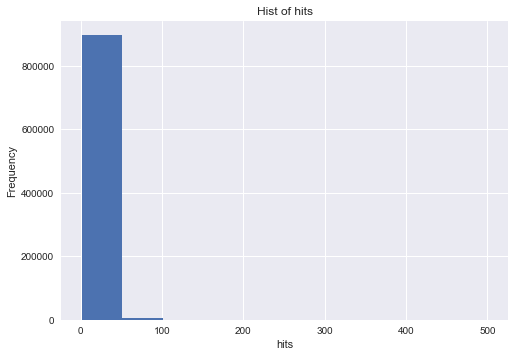

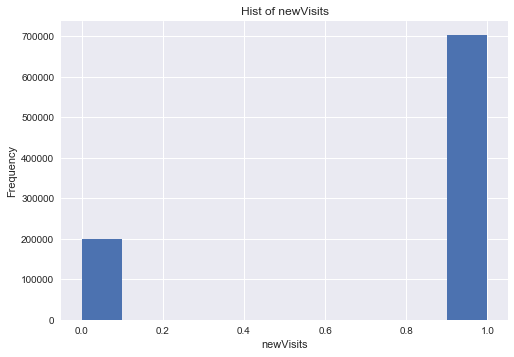

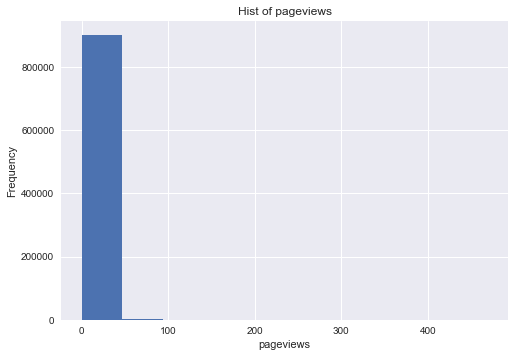

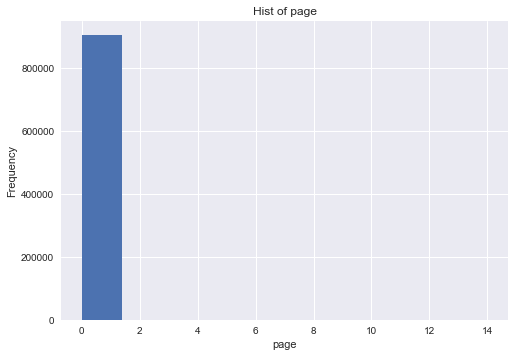

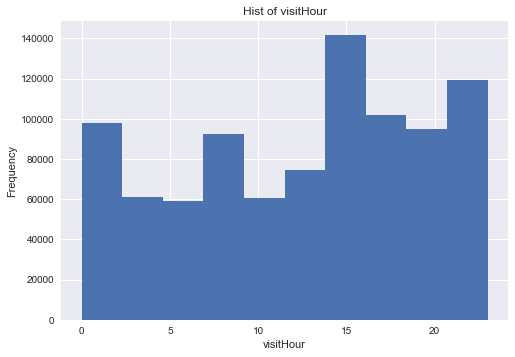

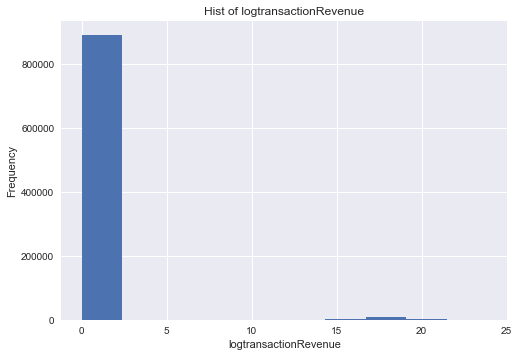

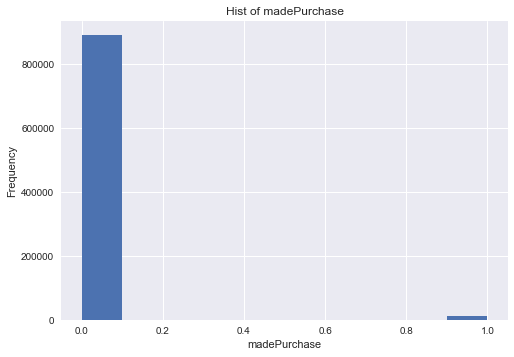

In [43]:
numeric_cols = train_data_v4.select_dtypes(include='number').columns
for i in numeric_cols:
    if i != 'visitId':
        plot_hist(train_data_v4[i], 10, 
          str(i), 'Frequency', 'Hist of ' + str(i))

Ideas for Modeling
1) Delete all records that contain a web browser with not purchases. Train a model to classify madepurchase and then train another model to predict the logtransaction revenue

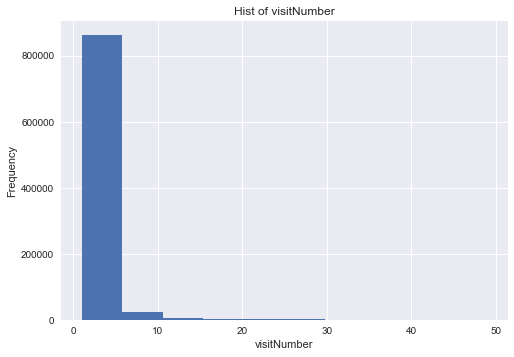

In [44]:
plot_hist(train_data_v4['visitNumber'][train_data_v4['visitNumber'] < 50], 10, 
          'visitNumber', 'Frequency', 'Hist of visitNumber')

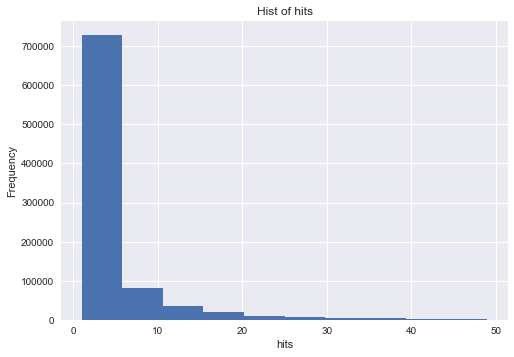

In [45]:
plot_hist(train_data_v4['hits'][train_data_v4['hits'] < 50], 10, 
          'hits', 'Frequency', 'Hist of hits')

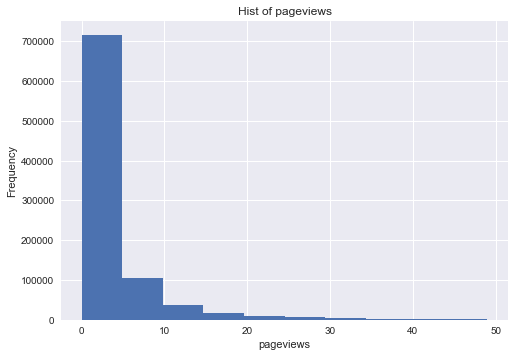

In [46]:
plot_hist(train_data_v4['pageviews'][train_data_v4['pageviews'] < 50], 10, 
          'pageviews', 'Frequency', 'Hist of pageviews')

In [47]:
numeric_data = train_data_v4.select_dtypes(include='number')
corr_LTR = pd.DataFrame(
    numeric_data.corrwith(numeric_data['logtransactionRevenue'], axis=0, drop=False), columns = ['corr'])
corr_LTR.sort_values(by='corr', ascending=False)

,corr
logtransactionRevenue,1.000000
madePurchase,0.997703
pageviews,0.400732
hits,0.378804
visitHour,0.026981
visitNumber,0.023666
page,0.010931
visitId,0.010491
newVisits,-0.108003
bounces,-0.113049


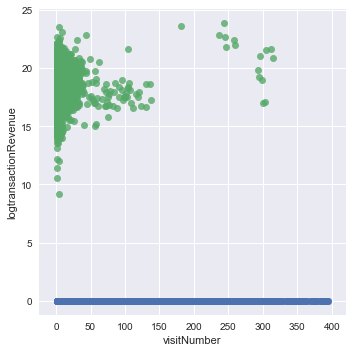

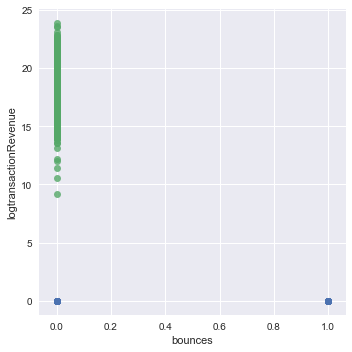

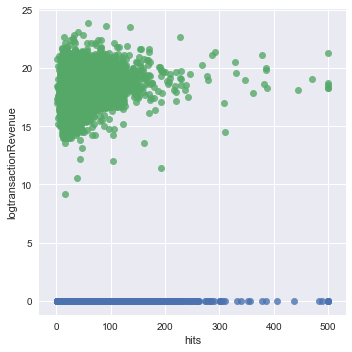

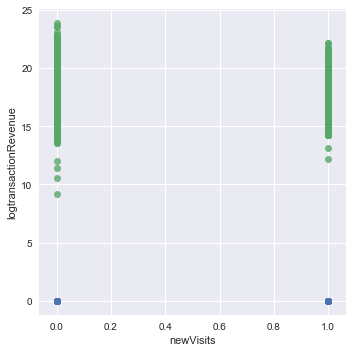

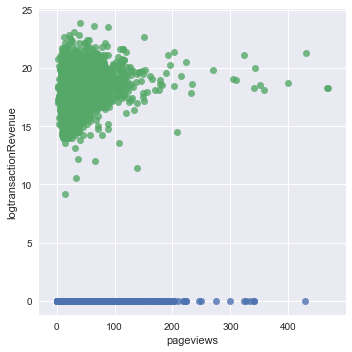

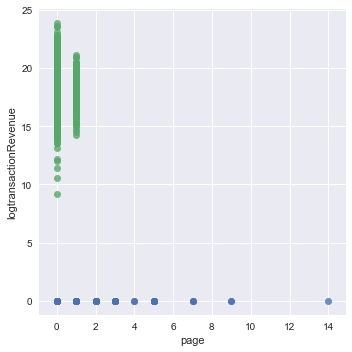

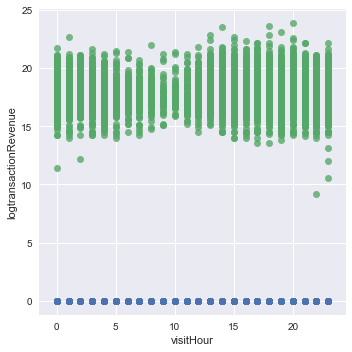

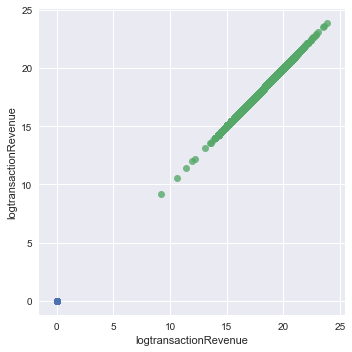

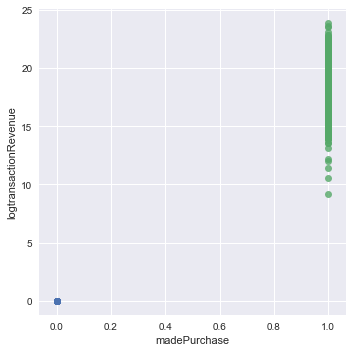

In [48]:
for i in numeric_cols:
    if i != 'visitId':
        plot_sns_scatter(train_data_v4, i, 'logtransactionRevenue', 'madePurchase')

# Model Implementation

### Idea 1
    - Run logistic regression for classification with a select few features
    - Run logistic regression to predict logtransactionrevenue for the rows that were classified as 1

### Logistic Regression Evaluation Metrics for Classification Model
    - confusion matrix
    - ROC curve
    - accuracy
    
Since this is the first iteration, no kfold
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [49]:
train_data_v5.columns

Index(['index', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'visitId', 'visitNumber', 'visitStartTime', 'browser', 'deviceCategory',
       'isMobile', 'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'adContent', 'campaign', 'campaignCode',
       'keyword', 'medium', 'referralPath', 'source', 'adNetworkType', 'gclId',
       'isVideoAd', 'page', 'slot', 'visitHour', 'logtransactionRevenue',
       'madePurchase', 'dayNameDate', 'monthDate', 'yearDate', 'dayDate'],
      dtype='object')

In [50]:
train_v1 = train_data_v5[['channelGrouping', 'visitNumber', 'deviceCategory', 'isMobile', 'country', 'continent', 'bounces', 
                          'hits','newVisits', 'pageviews', 'adContent', 'isVideoAd', 'page', 'slot', 
                          'visitHour', 'dayNameDate', 'monthDate', 'yearDate']]
y_v1 = train_data_v5['madePurchase'].astype(int)

In [51]:
train_v2 = pd.get_dummies(train_v1)

In [52]:
train_v2.shape
y_v1.shape

(902755,)

In [53]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(train_v2, y_v1, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

CPU times: user 28.6 s, sys: 7.35 s, total: 36 s
Wall time: 36.4 s


In [54]:
y_pred = logreg.predict(X_validate)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_validate, y_validate)))

Accuracy of logistic regression classifier on test set: 0.99


In [55]:
print(classification_report(y_validate, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    178218
          1       0.52      0.18      0.27      2333

avg / total       0.98      0.99      0.98    180551



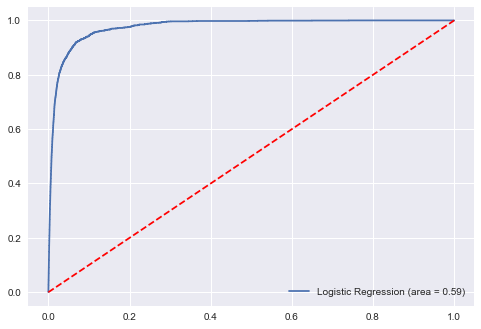

In [56]:
logit_roc_auc = roc_auc_score(y_validate, logreg.predict(X_validate))
fpr, tpr, thresholds = roc_curve(y_validate, logreg.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

### Try SMOTE to Even Out Samples

In [57]:
# sample a 100000 rows
subset_train_data_v5 = train_data_v5.sample(100000)

In [58]:
# making sure it has made_purchase = 1
subset_train_data_v5[subset_train_data_v5['madePurchase'] == 1].shape

(1292, 42)

In [59]:
X = subset_train_data_v5[['channelGrouping', 'visitNumber', 'deviceCategory', 'isMobile',
                          'continent', 'bounces', 'hits','newVisits', 'pageviews', 'adContent', 'isVideoAd',
                          'page', 'slot', 'visitHour', 'dayNameDate', 'monthDate']]
X_v1 = pd.get_dummies(X)
y = subset_train_data_v5['madePurchase']

In [60]:
os = SMOTE(random_state=0)
X_train, X_validate, y_train, y_validate = train_test_split(X_v1, y, test_size=0.2, random_state=0)
columns = X_train.columns

In [61]:
%%time
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

CPU times: user 1.24 s, sys: 135 ms, total: 1.37 s
Wall time: 1.22 s


In [62]:
print('This is the original number of rows of the subset sample:', y.shape[0])
print('This is the new number of rows of the subset sample:', os_data_y.shape[0])
print('Number of rows that have made a purchase increased from',
      y[y==1].shape[0],'to',os_data_y[os_data_y.y == 1].shape[0] )

This is the original number of rows of the subset sample: 100000
This is the new number of rows of the subset sample: 157902
Number of rows that have made a purchase increased from 1292 to 78951


In [63]:
os_data_X.shape

(157902, 68)

In [64]:
%%time
logreg = LogisticRegression()
rfe = RFE(logreg, 50)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True False  True  True  True
  True False False  True  True  True  True False False  True False  True
 False  True False False False  True  True  True False False  True  True
  True False  True  True  True  True  True  True]
[ 7  1  1  1  1  1  1  1 10  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  6  9  1  8  1  1  1  1 15 19  1  1  1  1 13 12  1 18  1
 14  1  2 11 17  1  1  1 16  5  1  1  1  3  1  1  1  1  1  1]
CPU times: user 29.7 s, sys: 754 ms, total: 30.4 s
Wall time: 30.6 s


In [65]:
col_bool = rfe.support_
rfe_cols = []
for i in enumerate(os_data_X.columns):
    if col_bool[i[0]] == True:
        rfe_cols.append(i[1])
os_data_X_rfe = os_data_X[rfe_cols]

In [66]:
os_data_X_rfe.shape

(157902, 50)

In [67]:
%%time
logit_model=sm.Logit(os_data_y,os_data_X_rfe)
result=logit_model.fit()
print(result.summary2())

/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [68]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(os_data_X_rfe, os_data_y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1.01 s, sys: 30.2 ms, total: 1.04 s
Wall time: 1.04 s


In [69]:
y_pred = logreg.predict(X_validate)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_validate, y_validate)))

Accuracy of logistic regression classifier on test set: 0.96


In [70]:
print(classification_report(y_validate, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.95      0.96     15670
          1       0.95      0.98      0.96     15911

avg / total       0.96      0.96      0.96     31581



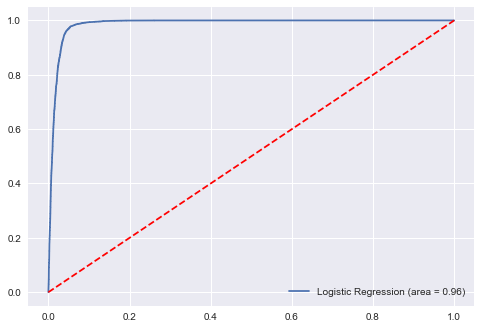

In [71]:
logit_roc_auc = roc_auc_score(y_validate, logreg.predict(X_validate))
fpr, tpr, thresholds = roc_curve(y_validate, logreg.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

In [72]:
os_data_X_rfe.head()

,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adContent_(not_set),adContent_20% discount,adContent_Ad from 12/13/16,adContent_Display Ad created 3/11/14,adContent_Display Ad created 3/11/15,adContent_First Full Auto Template Test Ad,adContent_Full auto ad IMAGE ONLY,adContent_Full auto ad with Primary Color,adContent_Google Merchandise,adContent_Google Merchandise Collection,adContent_Google Online Store,adContent_Swag with Google Logos,adContent_{KeyWord:Google Brand Items},adContent_{KeyWord:Google Branded Gear},adContent_{KeyWord:Google Men's T-Shirts},adContent_{KeyWord:Google Merchandise},adContent_{KeyWord:Looking for Google Bags?},slot_(not_set),slot_RHS,slot_Top,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Apply PCA on RFE Data and Plot to Identify Clusters

In [73]:
scaler = MinMaxScaler()
scaled_os_data_X_rfe = scaler.fit_transform(os_data_X_rfe)

In [74]:
scaled_os_data_X_rfe = pd.DataFrame(scaled_os_data_X_rfe)

In [75]:
pca = PCA(n_components=2)
pca_scaled_os_data_X_rfe = pca.fit_transform(scaled_os_data_X_rfe)

In [76]:
pca_scaled_os_data_X_rfe = pd.DataFrame(pca_scaled_os_data_X_rfe)

In [77]:
sns_plot_data = pd.concat([pca_scaled_os_data_X_rfe,os_data_y ], axis=1)

In [78]:
sns_plot_data.columns = ['x1', 'x2', 'y']

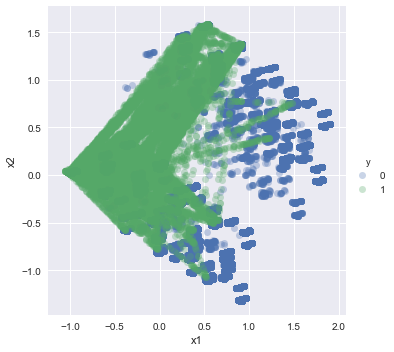

In [79]:
sns.lmplot('x1', 'x2', data=sns_plot_data, hue='y', scatter_kws={'alpha':0.3}, fit_reg=False)

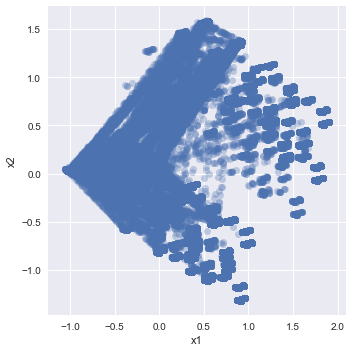

In [80]:
sns.lmplot('x1', 'x2', data=sns_plot_data, scatter_kws={'alpha':0.3}, fit_reg=False)

You can clearly see from the data that there is a difference between 1 and 0 for made purchases!

# Analyzing Columns with High Number of Unique Values

In [138]:
n_unique = pd.DataFrame(train_data_v5.nunique(), columns=['count_unique'])
n_unique = n_unique.sort_values(by='count_unique', ascending=False)
print('These are all the columns and the number of unique values in them:')
n_unique

These are all the columns and the number of unique values in them:


,count_unique
index,902755
sessionId,902755
visitId,886303
visitStartTime,886293
fullVisitorId,742532
networkDomain,28064
gclId,17775
logtransactionRevenue,5332
keyword,3660
referralPath,1476


### Focusing in on networkDomain

In [148]:
train_data_v5['networkDomain'] = train_data_v5['networkDomain'].replace(['unknown.unknown'], ['(not_set)'])

In [149]:
networkDomain = train_data_v5[['networkDomain','madePurchase']]

In [150]:
networkDomain['networkDomain'].value_counts()

(not_set)                            390535
comcast.net                           28688
rr.com                                14802
verizon.net                           13630
ttnet.com.tr                          13224
comcastbusiness.net                    9975
hinet.net                              7903
virginm.net                            6411
3bb.co.th                              6042
prod-infinitum.com.mx                  5957
cox.net                                5804
sbcglobal.net                          5378
btcentralplus.com                      5302
att.net                                5226
google.com                             5035
optonline.net                          4970
totbb.net                              4892
vnpt.vn                                4507
asianet.co.th                          4370
pldt.net                               4007
rima-tde.net                           3960
amazonaws.com                          3765
t-ipconnect.de                  

In [151]:
networkDomain['splitNetworkDomain'] = networkDomain['networkDomain'].str.split('.')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [152]:
networkDomain['topLevelDomain'] = networkDomain['networkDomain'].str.split('.').str[-1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
print('There are now', networkDomain['topLevelDomain'].nunique(), 'unique values for top level domain')

There are now 316 unique values for top level domain


In [154]:
print('Here are the value counts:')
networkDomain['topLevelDomain'].value_counts()

Here are the value counts:


(not_set)              390535
net                    180484
com                     84104
br                      14931
in                      14641
tr                      13997
jp                      13234
de                      11308
th                      10820
mx                      10408
vn                       9017
ca                       8684
edu                      8390
pl                       8256
it                       8145
au                       7626
ru                       7339
nl                       7206
fr                       5755
uk                       4459
ar                       4235
co                       3767
sg                       3489
ro                       3385
cz                       3303
org                      3065
se                       2691
id                       2594
es                       2493
ua                       2407
gr                       2341
ch                       2245
hu                       2227
at        

In [180]:
network_crosstab = pd.crosstab(networkDomain.topLevelDomain, networkDomain.madePurchase)
network_crosstab.sort_values(network_crosstab.columns[1], ascending = False)

In [196]:
def pop_network_domain(data):
    top_level_domain = ['(not_set)', '.us', '.net', '.com', '.edu', '.ca', '.org', '.mx' ]
    data_v1 = data
    for i in top_level_domain:
        col_name = 'tl_' + str(i)
        data_v1[col_name] = data_v1['networkDomain'].str.contains(i, case=1, na=0)
    return data_v1

In [192]:
networkDomain_v1 = pop_network_domain(networkDomain)
networkDomain_v1.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [197]:
train_data_v6 = pop_network_domain(train_data_v5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [200]:
train_data_v6.head()

,index,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,campaign,campaignCode,keyword,medium,referralPath,source,adNetworkType,gclId,isVideoAd,page,slot,visitHour,logtransactionRevenue,madePurchase,dayNameDate,monthDate,yearDate,dayDate,tl_(not_set),tl_.us,tl_.net,tl_.com,tl_.edu,tl_.ca,tl_.org,tl_.mx
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not_set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),15,0.0,0,Friday,9,2016,2,False,False,True,True,False,False,False,False
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,Macintosh,(not_set),Oceania,Australia,(not_set),dodo.net.au,(not_set),Australasia,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),5,0.0,0,Friday,9,2016,2,False,False,True,False,False,False,False,False
2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not_set),(not_set),Community of Madrid,Southern Europe,1,1,1,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),1,0.0,0,Friday,9,2016,2,True,False,False,False,False,False,False,False
3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,False,Linux,(not_set),Asia,Indonesia,(not_set),(not_set),(not_set),Southeast Asia,1,1,1,1,(not_set),(not_set),(not_set),google + online,organic,(not_set),google,(not_set),(not_set),True,0,(not_set),5,0.0,0,Friday,9,2016,2,True,False,False,False,False,False,False,False
4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,Android,(not_set),Europe,United Kingdom,(not_set),(not_set),(not_set),Northern Europe,1,1,0,1,(not_set),(not_set),(not_set),(not provided),organic,(not_set),google,(not_set),(not_set),True,0,(not_set),13,0.0,0,Friday,9,2016,2,True,False,False,False,False,False,False,False


In [199]:
train_data_v5.shape

(902755, 50)

### Focusing in on gclID

In [203]:
train_data_v6['gclId'].value_counts()

(not_set)                                                                                       881227
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ          70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ          41
CJH1vbf94M8CFUElgQodyakHgQ                                                                          29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ          27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB            24
CN_u9PaVhdACFcNahgodTCQAjw                                                                          22
CjwKEAiAxKrFBRDm25f60OegtwwSJABgEC-Z0_DLPcXHm1ZTqlR1YWeWXU875yaqwupt7pGMgFEZThoCeEzw_wcB            21
CNHp7Nf2ytMCFVlWDQod_IoL5A                                                                          20
CjwKEAiAvs7CBRC24rao6bGCoiASJABaCt5DtalFxcoSsvr2E2adUhx6z6OE0KAuVtqKzl-Bc

In [205]:
crosstab = pd.crosstab(train_data_v6.gclId, train_data_v6.madePurchase)
crosstab.sort_values(crosstab.columns[1], ascending = False)

madePurchase,0,1
gclId,,
(not_set),870169,11058
Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-14G-liUxzP7_Q4OI1bRc9np2-EnmI0-InsaAq108P8HAQ,3,3
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBExAsUjtkXuYAawLBg74jzCi7nH6wWoAshJH2ZmSvBABoCiALw_wcB,2,3
CjwKCAjwuOHHBRBmEiwAlEMW0B4j09Ol1dHOsKhSIJYpaA6fO2uZCAwUd6PriyuM10PHNpP90JfRrRoCcxwQAvD_BwE,2,3
CI2Tw4qu0tQCFQOMaQodjx8P2g,0,2
Cj0KEQjw4fy_BRCX7b6rq_WZgI0BEiQAl78ndxq9PGCMhcb72UXFt_ZDi6330mAni4I_mqPZiQK_urIaAh6D8P8HAQ,0,2
CjwKEAiAqJjDBRCG5KK6hq_juDwSJABRm03hn2fl7S-eRJYB48F0hYGU1g6DcZ4FZMH3Gl_rHkrdtBoCMKTw_wcB,0,2
CjwKEAjwwOvABRC08aedoZ_lnTMSJACs_cbuvO-lkchDMCCv8ny7UpX5q5pI_iZK1F4LP393wdlEDxoCQcfw_wcB,0,2
CjwKEAjwse7JBRCJ576SqoD7lCkSJABF-bKu8D8PN52p1AIcZjQ4I8I_saTnfpL5ilhIk8uNP50X_xoCle7w_wcB,1,2


Because of my lack of understanding of gclId I will not use this in the model

### Focusing on keyword

In [237]:
train_data_v6['keyword'] = train_data_v6['keyword'].replace(['(not provided)'], ['(not_set)'])

In [238]:
train_data_v6['keyword'].nunique()

3659

In [239]:
crosstab = pd.crosstab(train_data_v6.keyword, train_data_v6.madePurchase)
crosstab.sort_values(crosstab.columns[1], ascending = False)

madePurchase,0,1
keyword,,
(not_set),857405,11030
6qEhsCssdK0z36ri,11225,261
google merchandise store,2146,59
1hZbAqLCbjwfgOH7,2204,56
Google Merchandise,1597,45
(Remarketing/Content targeting),2286,9
+Google +Merchandise,344,7
1X4Me6ZKNV0zg-jV,461,6
+Google +Swag,61,3


In [357]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [358]:
def stem_sentences(sentence):
    sentence = re.sub('[^a-zA-Z]+', ' ', sentence)
    tokens = sentence.split()
    filtered_sentence = [w for w in tokens if not w in stop_words] 
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens if len(token) > 1]
    return ' '.join(stemmed_tokens)

In [360]:
%%time
porter_stemmer = PorterStemmer()
train_data_v6['cleanKeyword_v2'] = train_data_v6['keyword'].apply(stem_sentences)

CPU times: user 43.1 s, sys: 198 ms, total: 43.3 s
Wall time: 43.8 s


In [256]:
train_data_v6['cleanKeyword'].nunique()
train_data_v6['cleanKeyword_v2'].nunique()

2884

In [283]:
crosstab = pd.crosstab(train_data_v6.cleanKeyword_v2, train_data_v6.madePurchase)
crosstab.sort_values(crosstab.columns[1], ascending = False)

madePurchase,0,1
cleanKeyword_v2,,
not set,857405,11030
qehscssdk ri,11225,261
googl merchandis store,2471,61
hzbaqlcbjwfgoh,2204,56
googl merchandis,2205,55
remarket content target,2286,9
Me zknv zg jV,461,6
googl store,1828,6
googl gear,47,3


In [284]:
keyword_w_purchase = crosstab.sort_values(crosstab.columns[1], ascending = False)[1:7].index

In [285]:
keyword_w_purchase

Index(['qehscssdk ri', 'googl merchandis store', 'hzbaqlcbjwfgoh',
       'googl merchandis', 'remarket content target', 'Me zknv zg jV'],
      dtype='object', name='cleanKeyword_v2')

In [286]:
lst_words = []
for i in keyword_w_purchase:
    for j in i.split(' '):
        if len(j) > 2:
            lst_words.append(j)
lst_words      

['qehscssdk',
 'googl',
 'merchandis',
 'store',
 'hzbaqlcbjwfgoh',
 'googl',
 'merchandis',
 'remarket',
 'content',
 'target',
 'zknv']

In [287]:
lst_words_df = pd.DataFrame(lst_words, columns=['words'])

In [288]:
lst_words_df_v2 = pd.DataFrame(lst_words_df['words'].unique(), columns=['words'])

In [289]:
print(lst_words_df.shape)
print(lst_words_df_v2.shape)

(11, 1)
(9, 1)


In [299]:
lst_words_final = lst_words_df_v2['words'].values
lst_words_final

array(['qehscssdk', 'googl', 'merchandis', 'store', 'hzbaqlcbjwfgoh',
       'remarket', 'content', 'target', 'zknv'], dtype=object)

In [301]:
def transform_keyword(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words_final = ['qehscssdk', 'googl', 'merchandis', 'store', 'hzbaqlcbjwfgoh', 
                       'remarket', 'content', 'target', 'zknv']
    data_v1 = data
    data_v1['clean_keyword'] = data_v1['keyword'].apply(stem_sentences)
    for i in lst_words_final:
        col_name = 'keyword_' + str(i)
        data_v1[col_name] = data_v1['clean_keyword'].str.contains(i, case=1, na=0)
        
    return data_v1

In [ ]:
%%time
train_data_v7 = transform_keyword(train_data_v6)

### Focusing in on referralPath

In [370]:
train_data_v7['referralPath'] = train_data_v7['referralPath'].replace(['/'], ['(not_set)'])

In [371]:
pd.DataFrame(train_data_v7['referralPath'].unique())

,0
0,(not_set)
1,/corp/google.com/study/incentives/working-with...
2,/od/Things-To-Do-in-Silicon-Valley/fl/How-To-V...
3,/a/google.com/google-merchandise-store/on-site...
4,/analytics/web/
5,/intl/en/permissions/using-the-logo.html
6,/permissions/using-the-logo.html
7,/YKEI_mrn/items/c10b14f9a69ff71b1b7a
8,/analytics/web/inpage_launch
9,/intl/de/permissions/using-the-logo.html


In [422]:
crosstab = pd.crosstab(train_data_v6.referralPath, train_data_v6.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = crosstab[1]/crosstab[0]
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
referralPath,,,
/2610273/projects/12161610/todos/250267685,0,1,inf
/webmail/en-us/tablet,0,1,inf
/calendar/r/week/2017/7/8,1,1,1.000000
"/_/scs/mail-static/_/js/k=gmail.main.en.sXDiEpUnPe0.O/m=m_i,t,it/am=nhGvDGD-3_uDcQ3DgK701brz33u-Xyo_e7nH_ycDROlVoP_N_h_A_4H-tI0C/rt=h/d=1/rs=AHGWq9Bm-1qj1hhkb8cG9EpeilyYgWjoxA",1,1,1.000000
/KtfjgWJtWs,1,1,1.000000
"/_/scs/mail-static/_/js/k=gmail.main.en.yASPeSEQ5YQ.O/m=m_i,t/am=OotXDrD_7_3BuIZhQFf6at3573--_VR26Oce_58IiCKvAv3___8A_w_ko20U/rt=h/d=1/rs=AHGWq9DZAa74rKvcihAYhdWoJ70MBwYmVA",2,1,0.500000
/a/google.com/another-attempt-google-merchandise-store/mountain-view-on-site-merchandise-store,2,1,0.500000
/photos/google-dog-toy-21237.html,2,1,0.500000
/IUI6ugD07C,3,1,0.333333


In [423]:
filterd_crosstab = crosstab[(crosstab[1] > 5) & (crosstab[2] > 0.01) & (crosstab.index != "(not_set)")]
filterd_crosstab

madePurchase,0,1,2
referralPath,,,
/deal/-ds-sign-up-for-google-merchandise-store-emails-for-special-coup-c179,96,17,0.177083
/google-merchandise-store,359,22,0.061281
/mail/u/0/,978,55,0.056237
/a/google.com/forum/,715,35,0.048951
/2015/03/11/google-merch-store-new-url/,216,6,0.027778
/a/google.com/google-merchandise-store/on-site-store/mountain-view-store,507,11,0.021696
/l.php,414,8,0.019324
/a/google.com/google-merchandise-store/on-site-store,495,9,0.018182
/offer/2145,1046,18,0.017208


In [374]:
filterd_crosstab_index = pd.DataFrame(filterd_crosstab.index)
filterd_crosstab_index

,referralPath
0,/deal/-ds-sign-up-for-google-merchandise-store...
1,/google-merchandise-store
2,/mail/u/0/
3,/a/google.com/forum/
4,/2015/03/11/google-merch-store-new-url/
5,/a/google.com/google-merchandise-store/on-site...
6,/l.php
7,/a/google.com/google-merchandise-store/on-site...
8,/offer/2145
9,/a/google.com/googletopia/discounts-deals-and-...


In [407]:
a = 'hela  ssd  '
a.strip()

'hela  ssd'

In [409]:
def stem_sentences_v2(sentence):
    sentence = re.sub('[^a-zA-Z]+', ' ', sentence)
    tokens = sentence.split('/')
    filtered_sentence = [w for w in tokens if not w in stop_words] 
    stemmed_tokens = [porter_stemmer.stem(token.strip()) for token in tokens if len(token) > 1]
    return ''.join(stemmed_tokens)

In [410]:
filterd_crosstab_index['split'] = filterd_crosstab_index['referralPath'].apply(stem_sentences_v2)

In [411]:
split_lst = filterd_crosstab_index['split'].values
split_lst

array(['deal ds sign up for google merchandise store emails for special coup c',
       'google merchandise stor', 'mail u', 'a google com forum',
       'google merch store new url',
       'a google com google merchandise store on site store mountain view stor',
       'l php', 'a google com google merchandise store on site stor',
       'offer',
       'a google com googletopia discounts deals and free stuff alphabet google discount'],
      dtype=object)

In [425]:
lst_split_words = []
for i in split_lst:
    for j in i.split(' '):
        if len(j) > 2:
            lst_split_words.append(j)
lst_split_words_df = pd.DataFrame(lst_split_words, columns=['words'])
lst_split_words_df_unique = lst_split_words_df['words'].unique()
lst_split_words_df_unique

array(['deal', 'sign', 'for', 'google', 'merchandise', 'store', 'emails',
       'special', 'coup', 'stor', 'mail', 'com', 'forum', 'merch', 'new',
       'url', 'site', 'mountain', 'view', 'php', 'offer', 'googletopia',
       'discounts', 'deals', 'and', 'free', 'stuff', 'alphabet',
       'discount'], dtype=object)

In [427]:
def transform_referralPath(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words_final = ['deal', 'sign', 'google', 'merchandise', 'store', 'emails',
                       'special', 'coup', 'stor', 'mail', 'com', 'forum', 'merch', 'new',
                       'url', 'site', 'mountain', 'view', 'php', 'offer', 'googletopia', 
                       'free', 'stuff', 'alphabet','discount']
    data_v1 = data
    data_v1['clean_referralPath'] = data_v1['referralPath'].apply(stem_sentences_v2)
    for i in lst_words_final:
        col_name = 'referralPath_' + str(i)
        data_v1[col_name] = data_v1['clean_referralPath'].str.contains(i, case=1, na=0)
        
    return data_v1

In [428]:
%%time
train_data_v8 = transform_referralPath(train_data_v7)

CPU times: user 34.9 s, sys: 198 ms, total: 35.1 s
Wall time: 35.3 s


### Focusing in on source

In [432]:
pd.DataFrame(train_data_v8['source'].unique())

,0
0,google
1,baidu
2,googleweblight.com
3,sites.google.com
4,bing
5,siliconvalley.about.com
6,analytics.google.com
7,Partners
8,(direct)
9,mall.googleplex.com


In [447]:
crosstab = pd.crosstab(train_data_v8.source, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
source,,,
basecamp.com,1,1,1.00
mail.aol.com,2,1,0.50
us-mg5.mail.yahoo.com,3,1,0.33
calendar.google.com,4,1,0.25
chat.google.com,6,1,0.17
mg.mail.yahoo.com,29,4,0.14
search.myway.com,7,1,0.14
gatewaycdi.com,9,1,0.11
trainup.withgoogle.com,23,2,0.09


In [449]:
filterd_crosstab = crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filterd_crosstab_index = filterd_crosstab.index
filterd_crosstab

madePurchase,0,1,2
source,,,
mall.googleplex.com,61240,5103,0.08
dealspotr.com,488,40,0.08
mail.google.com,1394,62,0.04
groups.google.com,987,38,0.04
phandroid.com,216,6,0.03
gdeals.googleplex.com,1045,18,0.02
dfa,5560,123,0.02
l.facebook.com,779,13,0.02
yahoo,1455,22,0.02


In [450]:
filterd_crosstab_index = filterd_crosstab.index
filterd_crosstab_index

Index(['mall.googleplex.com', 'dealspotr.com', 'mail.google.com',
       'groups.google.com', 'phandroid.com', 'gdeals.googleplex.com', 'dfa',
       'l.facebook.com', 'yahoo', 'google', 'bing', 'sites.google.com',
       '(direct)', 'facebook.com'],
      dtype='object', name='source')

In [474]:
def transform_source(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['mall.googleplex.com', 'dealspotr.com', 'mail.google.com',
       'groups.google.com', 'phandroid.com', 'gdeals.googleplex.com', 'dfa',
       'l.facebook.com', 'yahoo', 'google', 'bing', 'sites.google.com',
       '(direct)', 'facebook.com']
    data_v1 = data
    for i in lst_words:
        col_name = 'source_' + str(i)
        data_v1[col_name] = data_v1['source'].str.contains(i, case=1, na=0)
    return data_v1

In [475]:
%%time
train_data_v9 = transform_source(train_data_v8)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 8.12 s, sys: 84.1 ms, total: 8.2 s
Wall time: 8.21 s


In [477]:
train_data_v9.shape

(902755, 104)

### Focusing in on region

In [466]:
crosstab = pd.crosstab(train_data_v8.region, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab[:34]

madePurchase,0,1,2
region,,,
Zulia,202,35,0.17
Nebraska,30,4,0.13
Michigan,2383,194,0.08
Pichincha,16,1,0.06
Tennessee,198,11,0.06
Illinois,7160,423,0.06
New York,24918,1507,0.06
Washington,7302,336,0.05
Massachusetts,2502,137,0.05


In [467]:
filtered_crosstab_index = crosstab[:34].index
filtered_crosstab_index

Index(['Zulia', 'Nebraska', 'Michigan', 'Pichincha', 'Tennessee', 'Illinois',
       'New York', 'Washington', 'Massachusetts', 'Colorado', 'South Carolina',
       'Texas', 'Georgia', 'Missouri', 'Iowa', 'District of Columbia',
       'California', 'Minnesota', 'Utah', 'Arizona', 'Pennsylvania',
       'New Jersey', 'Indiana', 'Florida', 'Maryland', 'Connecticut',
       'North Carolina', 'Virginia', 'Nevada', 'Ohio', 'Alberta', '(not_set)',
       'Ontario', 'Oregon'],
      dtype='object', name='region')

In [479]:
def transform_region(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Zulia', 'Nebraska', 'Michigan', 'Pichincha', 'Tennessee', 'Illinois',
       'New York', 'Washington', 'Massachusetts', 'Colorado', 'South Carolina',
       'Texas', 'Georgia', 'Missouri', 'Iowa', 'District of Columbia',
       'California', 'Minnesota', 'Utah', 'Arizona', 'Pennsylvania',
       'New Jersey', 'Indiana', 'Florida', 'Maryland', 'Connecticut',
       'North Carolina', 'Virginia', 'Nevada', 'Ohio', 'Alberta', '(not_set)',
       'Ontario', 'Oregon']
    data_v1 = data
    for i in lst_words:
        col_name = 'source_' + str(i)
        data_v1[col_name] = data_v1['source'].str.contains(i, case=1, na=0)
    return data_v1

In [480]:
train_data_v10 = transform_region(train_data_v9)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


### Focusing in on channelGrouping and medium

In [503]:
train_data_v10['channelGrouping'].unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [504]:
train_data_v10['medium'].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not_set)'], dtype=object)

In [505]:
test = train_data_v10[['medium', 'channelGrouping']]

In [506]:
test["med_channel"] = test["medium"].map(str) + '_' + test["channelGrouping"].map(str)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [507]:
test['med_channel'].unique()

array(['organic_Organic Search', 'referral_Referral', 'cpc_Paid Search',
       'affiliate_Affiliates', '(none)_Direct', 'cpm_Display',
       'referral_Social', '(not_set)_(Other)'], dtype=object)

Decided to delete the medium column and just keep channel grouping

In [508]:
train_data_v11 = train_data_v10.drop(columns = ['medium'])

### Focusing in on operatingSystem

In [515]:
train_data_v11['operatingSystem'].unique()

array(['Windows', 'Macintosh', 'Linux', 'Android', 'iOS', 'Chrome OS',
       'BlackBerry', '(not_set)', 'Samsung', 'Windows Phone', 'Xbox',
       'Nintendo Wii', 'Firefox OS', 'Nintendo WiiU', 'FreeBSD', 'Nokia',
       'NTT DoCoMo', 'Nintendo 3DS', 'SunOS', 'OpenBSD'], dtype=object)

In [518]:
crosstab = pd.crosstab(train_data_v8.operatingSystem, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
operatingSystem,,,
Chrome OS,25314,994,0.04
Macintosh,247260,6426,0.03
Linux,34229,782,0.02
iOS,107021,536,0.01
Windows,347403,2308,0.01
(not_set),4690,0,0.00
BlackBerry,218,0,0.00
Firefox OS,89,0,0.00
FreeBSD,9,0,0.00


In [520]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
operatingSystem,,,
Chrome OS,25314,994,0.04
Macintosh,247260,6426,0.03
Linux,34229,782,0.02
iOS,107021,536,0.01
Windows,347403,2308,0.01


In [523]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['Chrome OS', 'Macintosh', 'Linux', 'iOS', 'Windows'], dtype=object)

In [525]:
def transform_operatingSystem(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Chrome OS', 'Macintosh', 'Linux', 'iOS', 'Windows']
    data_v1 = data
    for i in lst_words:
        col_name = 'operatingSystem_' + str(i)
        data_v1[col_name] = data_v1['operatingSystem'].str.contains(i, case=1, na=0)
    return data_v1

In [526]:
train_data_v12 = transform_operatingSystem(train_data_v11)

### Focusing in on adContent

In [528]:
train_data_v11['adContent'].unique()

array(['(not_set)', 'Full auto ad IMAGE ONLY',
       'First Full Auto Template Test Ad', '{KeyWord:Google Brand Items}',
       'Display Ad created 3/11/14', 'Ad from 11/7/16',
       'Display Ad created 3/11/15', 'Ad from 12/13/16',
       'Ad from 11/3/16', 'Google Online Store',
       'Google Merchandise Collection', '{KeyWord:Want Google Stickers?}',
       '{KeyWord:Google Merchandise}', 'Display Ad created 11/17/14',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Google Paraphernalia',
       'Swag with Google Logos', '{KeyWord:Google Branded Kit}',
       'Want Google Sunglasses', '{KeyWord:Looking for Google Bags?}',
       'Full auto ad TEXT ONLY', 'Google Merchandise', 'google store',
       'LeEco_1a', 'Full auto ad TEXT/NATIVE',
       '{KeyWord:Want Google Pet Toys?}', 'Google Store',
       "Men's-Outerwear Google Apparel", '20% discount',
       'Full auto ad wi

In [530]:
crosstab = pd.crosstab(train_data_v8.adContent, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
adContent,,,
{KeyWord:Want Google Stickers?},40,2,0.05
{KeyWord:Google Branded Gear},64,3,0.05
Swag with Google Logos,60,3,0.05
{KeyWord:Google Drinkware},31,1,0.03
{KeyWord:Google Men's T-Shirts},29,1,0.03
20% discount,73,2,0.03
Display Ad created 11/17/14,49,1,0.02
Google Merchandise Collection,4995,117,0.02
(not_set),880453,11371,0.01


In [531]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
adContent,,,
Google Merchandise Collection,4995,117,0.02
(not_set),880453,11371,0.01


In [532]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['Google Merchandise Collection', '(not_set)'], dtype=object)

In [533]:
def transform_adContent(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Google Merchandise Collection', '(not_set)']
    data_v1 = data
    for i in lst_words:
        col_name = 'adContent' + str(i)
        data_v1[col_name] = data_v1['adContent'].str.contains(i, case=1, na=0)
    return data_v1

In [534]:
train_data_v13 = transform_adContent(train_data_v12)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


### Focusing in on Browser

In [536]:
train_data_v13['browser'].unique()

array(['Chrome', 'Firefox', 'UC Browser', 'Internet Explorer', 'Safari',
       'Edge', 'Opera Mini', 'Opera', 'BlackBerry', 'Safari (in-app)',
       'Coc Coc', 'Mozilla Compatible Agent', 'ADM', 'MRCHROME',
       'Amazon Silk', 'YaBrowser', 'Android Webview', 'Puffin',
       'Nokia Browser', 'Maxthon', 'Nintendo Browser', 'Android Browser',
       'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'Mozilla', 'osee2unifiedRelease', 'NokiaE52-1',
       'Iron', '[Use default User-agent string] LIVRENPOCHE', '(not_set)',
       'LYF_LS_4002_11', 'M5', 'Android Runtime', 'Apple-iPhone7C2',
       'SeaMonkey', 'Konqueror', 'Seznam', 'Changa 99695759', 'no-ua',
       'MQQBrowser', 'Nichrome', 'HTC802t_TD', 'DASH_JR_3G', 'DoCoMo',
       'subjectAgent: NoticiasBoom', 'YE', 'User Agent', '0',
       'Hisense M20-M_LTE', 'Reddit', 'TCL P500M', 'CSM Click'],
      dtype=object)

In [538]:
crosstab = pd.crosstab(train_data_v8.browser, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
browser,,,
Chrome,609347,10352,0.02
Firefox,36848,191,0.01
Internet Explorer,19249,109,0.01
Edge,10139,58,0.01
DASH_JR_3G,4,0,0.00
Maxthon,246,0,0.00
DoCoMo,1,0,0.00
ADM,1,0,0.00
Android Browser,552,0,0.00


In [539]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
browser,,,
Chrome,609347,10352,0.02
Firefox,36848,191,0.01
Internet Explorer,19249,109,0.01
Edge,10139,58,0.01


In [540]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['Chrome', 'Firefox', 'Internet Explorer', 'Edge'], dtype=object)

In [542]:
def transform_browser(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Chrome', 'Firefox', 'Internet Explorer', 'Edge']
    data_v1 = data
    for i in lst_words:
        col_name = 'browser' + str(i)
        data_v1[col_name] = data_v1['browser'].str.contains(i, case=1, na=0)
    return data_v1

In [543]:
train_data_v14 = transform_browser(train_data_v13)

In [544]:
train_data_v14.head()

,index,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,campaign,campaignCode,keyword,referralPath,source,adNetworkType,gclId,isVideoAd,page,slot,visitHour,logtransactionRevenue,madePurchase,dayNameDate,monthDate,yearDate,dayDate,tl_(not_set),tl_.us,tl_.net,tl_.com,tl_.edu,tl_.ca,tl_.org,tl_.mx,cleanKeyword,cleanKeyword_v1,cleanKeyword_v2,clean_keyword,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,clean_referralPath,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,clean_source,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,source_Zulia,source_Nebraska,source_Michigan,source_Pichincha,source_Tennessee,source_Illinois,source_New York,source_Washington,source_Massachusetts,source_Colorado,source_South Carolina,source_Texas,source_Georgia,source_Missouri,source_Iowa,source_District of Columbia,source_California,source_Minnesota,source_Utah,source_Arizona,source_Pennsylvania,source_New Jersey,source_Indiana,source_Florida,source_Maryland,source_Connecticut,source_North Carolina,source_Virginia,source_Nevada,source_Ohio,source_Alberta,source_(not_set),source_Ontario,source_Oregon,operatingSystem_Chrome OS,operatingSystem_Macintosh,operatingSystem_Linux,operatingSystem_iOS,operatingSystem_Windows,adContentGoogle Merchandise Collection,adContent(not_set),browserChrome,browserFirefox,browserInternet Explorer,browserEdge
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not_set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,(not_set),(not_set),(not_set),(not_set),(not_set),google,(not_set),(not_set),True,0,(not_set),15,0.0,0,Friday,9,2016,2,False,False,True,True,False,False,False,False,(not provided),not provid,not set,not set,False,False,False,False,False,False,False,False,False,not set,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,googl,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False
1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,Macintosh,(not_set),Oceania,Australia,(not_set),dodo.net.au,(not_set),Australasia,1,1,1,1,(not_set),(not_set),(not_set),(not_set),(not_set),google,(not_set),(not_set),True,0,(not_set),5,0.0,0,Friday,9,2016,2,False,False,True,False,False,False,False,False,(not provided),not provid,not set,not set,False,False,False,False,False,False,False,False,False,not set,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,googl,False,False,False,False,False,False,False,False,False,True,False,False,False,F

### Focusing in on metro

In [547]:
train_data_v14['metro'].unique()

array(['(not_set)', 'London', 'San Francisco-Oakland-San Jose CA',
       'New York NY', 'Washington DC (Hagerstown MD)', 'Los Angeles CA',
       'Seattle-Tacoma WA', 'Chicago IL', 'Boston MA-Manchester NH',
       'Detroit MI', 'Austin TX', 'Pittsburgh PA', 'Roanoke-Lynchburg VA',
       'Dallas-Ft. Worth TX', 'Portland OR', 'Denver CO', 'Houston TX',
       'Atlanta GA', 'San Diego CA', 'Phoenix AZ', 'Columbus OH',
       'Charlotte NC', 'Jacksonville FL',
       'Meridian (exc. Channel Islands)', 'Midlands', 'Las Vegas NV',
       'La Crosse-Eau Claire WI', 'Springfield-Holyoke MA',
       'Green Bay-Appleton WI', 'San Antonio TX', 'North West',
       'Minneapolis-St. Paul MN', 'Philadelphia PA', 'Indianapolis IN',
       'Chico-Redding CA', 'Orlando-Daytona Beach-Melbourne FL',
       'Norfolk-Portsmouth-Newport News VA', 'Miami-Ft. Lauderdale FL',
       'JP_KANTO', 'Central Scotland', 'Omaha NE',
       'Tampa-St. Petersburg (Sarasota) FL', 'Nashville TN',
       'Salt Lake Cit

In [549]:
crosstab = pd.crosstab(train_data_v8.metro, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
metro,,,
"Providence-New Bedford,MA",4,1,0.25
Syracuse NY,6,1,0.17
Detroit MI,2209,194,0.09
Omaha NE,121,8,0.07
Charleston SC,49,3,0.06
Austin TX,3575,210,0.06
Chicago IL,7160,423,0.06
Nashville TN,180,11,0.06
New York NY,25391,1518,0.06


Decided to use region instead of metro since it is cleaner!

In [550]:
train_data_v15= train_data_v14.drop(columns=['metro'])

### Focusing in on country

In [555]:
crosstab = pd.crosstab(train_data_v8.country, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
country,,,
Anguilla,0,1,inf
St. Lucia,22,2,0.090000
Guadeloupe,28,1,0.040000
United States,353449,10953,0.030000
Venezuela,2066,62,0.030000
Curaçao,29,1,0.030000
Puerto Rico,720,11,0.020000
Canada,25660,190,0.010000
Nicaragua,137,1,0.010000


In [556]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
country,,,
United States,353449,10953,0.03
Venezuela,2066,62,0.03
Puerto Rico,720,11,0.02
Canada,25660,190,0.01


In [557]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['United States', 'Venezuela', 'Puerto Rico', 'Canada'],
      dtype=object)

In [560]:
def transform_country(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['United States', 'Venezuela', 'Puerto Rico', 'Canada']
    data_v1 = data
    for i in lst_words:
        col_name = 'country' + str(i)
        data_v1[col_name] = data_v1['country'].str.contains(i, case=1, na=0)
    return data_v1

In [561]:
train_data_v16 = transform_country(train_data_v15)

### Focusing in on campaign

In [564]:
crosstab = pd.crosstab(train_data_v8.campaign, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
campaign,,,
AW - Dynamic Search Ads Whole Site,13900,323,0.02
AW - Accessories,6928,130,0.02
AW - Apparel,45,1,0.02
Retail (DO NOT EDIT owners nophakun and tianyu),49,1,0.02
(not_set),853465,11049,0.01
Data Share Promo,16363,9,0.00
test-liyuhz,390,1,0.00
AW - Electronics,96,0,0.00
All Products,4,0,0.00


In [565]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
campaign,,,
AW - Dynamic Search Ads Whole Site,13900,323,0.02
AW - Accessories,6928,130,0.02
(not_set),853465,11049,0.01


In [566]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['AW - Dynamic Search Ads Whole Site', 'AW - Accessories',
       '(not_set)'], dtype=object)

In [567]:
def transform_campaign(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['AW - Dynamic Search Ads Whole Site', 'AW - Accessories', '(not_set)']
    data_v1 = data
    for i in lst_words:
        col_name = 'campaign' + str(i)
        data_v1[col_name] = data_v1['campaign'].str.contains(i, case=1, na=0)
    return data_v1

In [568]:
train_data_v17 = transform_campaign(train_data_v16)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


### Focusing in on subContinent

In [573]:
crosstab = pd.crosstab(train_data_v8.subContinent, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
subContinent,,,
Northern America,379153,11143,0.03
Caribbean,2389,16,0.01
Southern Europe,35744,8,0.00
Micronesian Region,55,0,0.00
Middle Africa,390,0,0.00
Polynesia,25,0,0.00
Northern Africa,7677,1,0.00
Central Asia,1213,2,0.00
Western Africa,2569,2,0.00


decided to delete the continent column and just keep one or two one hotebcoding columns from the subcontinent

In [574]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
subContinent,,,
Northern America,379153,11143,0.03
Caribbean,2389,16,0.01


In [575]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['Northern America', 'Caribbean'], dtype=object)

In [576]:
def transform_subContinent(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Northern America', 'Caribbean']
    data_v1 = data
    for i in lst_words:
        col_name = 'subContinent' + str(i)
        data_v1[col_name] = data_v1['subContinent'].str.contains(i, case=1, na=0)
    return data_v1

In [577]:
train_data_v18 = transform_subContinent(train_data_v17)

### Focusing in on city

In [580]:
train_data_v15['city'].unique()

array(['Izmir', '(not_set)', 'Madrid', 'Brisbane', 'Karachi', 'Paris',
       'Singapore', 'Buenos Aires', 'Bangkok', 'Jakarta', 'Bengaluru',
       'London', 'Amsterdam', 'Moscow', 'Kolkata', 'Seoul', 'Santiago',
       'Warsaw', 'Dublin', 'Mexico City', 'Barcelona', 'Sao Paulo',
       'Mountain View', 'Istanbul', 'Dubai', 'New Delhi', 'Sydney',
       'New York', 'Rio de Janeiro', 'Hyderabad', 'Toronto', 'Washington',
       'Los Angeles', 'Pune', 'San Francisco', 'Seattle', 'Palo Alto',
       'Santa Clara', 'Mumbai', 'Colombo', 'Rome', 'Chicago', 'Nairobi',
       'Boston', 'Tel Aviv-Yafo', 'La Victoria', 'Sunnyvale', 'Ann Arbor',
       'San Jose', 'Austin', 'Pittsburgh', 'Montreal', 'Cupertino',
       'Salem', 'Ho Chi Minh City', 'Hanoi', 'Tunis', 'Monterrey',
       'Ankara', 'Quezon City', 'Budapest', 'Minato', 'Dallas',
       'Vancouver', 'Kirkland', 'Yokohama', 'Stockholm', 'Tigard',
       'Fremont', 'Boulder', 'Munich', 'Chennai', 'Kiev', 'Houston',
       'Hong Kong', '

In [581]:
crosstab = pd.crosstab(train_data_v8.city, train_data_v8.madePurchase)
crosstab = crosstab.sort_values(crosstab.columns[1], ascending = False)
crosstab[2] = round(crosstab[1]/crosstab[0],2)
crosstab = crosstab.sort_values(crosstab.columns[2], ascending = False)
crosstab

madePurchase,0,1,2
city,,,
Atwater,6,2,0.33
North Attleborough,4,1,0.25
Sandy Springs,5,1,0.20
Fort Worth,10,2,0.20
Maracaibo,195,35,0.18
Fort Collins,6,1,0.17
Syracuse,6,1,0.17
Milwaukee,6,1,0.17
Walnut Creek,7,1,0.14


In [582]:
filtered_crosstab =  crosstab[(crosstab[1] > 5) & (crosstab[2] >= 0.01)]
filtered_crosstab

madePurchase,0,1,2
city,,,
Maracaibo,195,35,0.18
Ann Arbor,2048,193,0.09
Cambridge,1466,119,0.08
San Bruno,1583,103,0.07
Chicago,7020,422,0.06
Austin,3575,210,0.06
Irvine,900,53,0.06
New York,24857,1506,0.06
Nashville,174,11,0.06


In [585]:
filtered_crosstab_index = filtered_crosstab.index.values
filtered_crosstab_index

array(['Maracaibo', 'Ann Arbor', 'Cambridge', 'San Bruno', 'Chicago',
       'Austin', 'Irvine', 'New York', 'Nashville', 'Jersey City',
       'Boulder', 'Kirkland', 'Seattle', 'Oakland', 'Denver', 'Sunnyvale',
       'San Francisco', 'Pittsburgh', 'Washington', 'Atlanta',
       'Los Angeles', 'Mountain View', 'Minneapolis', 'San Antonio',
       'Lake Oswego', 'Santa Clara', 'Cupertino', 'Salem', 'San Mateo',
       'San Diego', 'Palo Alto', 'Fremont', 'Houston', 'Milpitas',
       'Boston', 'Charlotte', 'San Jose', 'Philadelphia', 'Redwood City',
       'Portland', 'Phoenix', '(not_set)', 'Toronto', 'Dallas'],
      dtype=object)

In [586]:
def transform_city(data):
    # given the data, want to make binary columns stating that they contain necessary keywords 
    lst_words = ['Maracaibo', 'Ann Arbor', 'Cambridge', 'San Bruno', 'Chicago',
       'Austin', 'Irvine', 'New York', 'Nashville', 'Jersey City',
       'Boulder', 'Kirkland', 'Seattle', 'Oakland', 'Denver', 'Sunnyvale',
       'San Francisco', 'Pittsburgh', 'Washington', 'Atlanta',
       'Los Angeles', 'Mountain View', 'Minneapolis', 'San Antonio',
       'Lake Oswego', 'Santa Clara', 'Cupertino', 'Salem', 'San Mateo',
       'San Diego', 'Palo Alto', 'Fremont', 'Houston', 'Milpitas',
       'Boston', 'Charlotte', 'San Jose', 'Philadelphia', 'Redwood City',
       'Portland', 'Phoenix', '(not_set)', 'Toronto', 'Dallas']
    data_v1 = data
    for i in lst_words:
        col_name = 'city' + str(i)
        data_v1[col_name] = data_v1['city'].str.contains(i, case=1, na=0)
    return data_v1

In [587]:
train_data_v19 = transform_city(train_data_v18)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [588]:
train_data_v19.head()

,index,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,campaign,campaignCode,keyword,referralPath,source,adNetworkType,gclId,isVideoAd,page,slot,visitHour,logtransactionRevenue,madePurchase,dayNameDate,monthDate,yearDate,dayDate,tl_(not_set),tl_.us,tl_.net,tl_.com,tl_.edu,tl_.ca,tl_.org,tl_.mx,cleanKeyword,cleanKeyword_v1,cleanKeyword_v2,clean_keyword,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,clean_referralPath,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,clean_source,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,source_Zulia,source_Nebraska,source_Michigan,source_Pichincha,source_Tennessee,source_Illinois,source_New York,source_Washington,source_Massachusetts,source_Colorado,source_South Carolina,source_Texas,source_Georgia,source_Missouri,source_Iowa,source_District of Columbia,source_California,source_Minnesota,source_Utah,source_Arizona,source_Pennsylvania,source_New Jersey,source_Indiana,source_Florida,source_Maryland,source_Connecticut,source_North Carolina,source_Virginia,source_Nevada,source_Ohio,source_Alberta,source_(not_set),source_Ontario,source_Oregon,operatingSystem_Chrome OS,operatingSystem_Macintosh,operatingSystem_Linux,operatingSystem_iOS,operatingSystem_Windows,adContentGoogle Merchandise Collection,adContent(not_set),browserChrome,browserFirefox,browserInternet Explorer,browserEdge,countryUnited States,countryVenezuela,countryPuerto Rico,countryCanada,campaignAW - Dynamic Search Ads Whole Site,campaignAW - Accessories,campaign(not_set),subContinentNorthern America,subContinentCaribbean,cityMaracaibo,cityAnn Arbor,cityCambridge,citySan Bruno,cityChicago,cityAustin,cityIrvine,cityNew York,cityNashville,cityJersey City,cityBoulder,cityKirkland,citySeattle,cityOakland,cityDenver,citySunnyvale,citySan Francisco,cityPittsburgh,cityWashington,cityAtlanta,cityLos Angeles,cityMountain View,cityMinneapolis,citySan Antonio,cityLake Oswego,citySanta Clara,cityCupertino,citySalem,citySan Mateo,citySan Diego,cityPalo Alto,cityFremont,cityHouston,cityMilpitas,cityBoston,cityCharlotte,citySan Jose,cityPhiladelphia,cityRedwood City,cityPortland,cityPhoenix,city(not_set),cityToronto,cityDallas
0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,ttnet.com.tr,Izmir,Western Asia,1,1,1,1,(not_set),(not_set),(not_set),(not_set),(not_set),google,(not_set),(not_set),True,0,(not_set),15,0.0,0,Friday,9,2016,2,False,False,True,True,False,False,False,False,(not provided),not provid,not set,not set,False,False,False,False,False,False,False,False,False,not set,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,googl,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

# Methods to Do all Data Cleaning and Feature Engineering

In [37]:
%%time
train_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/train.csv')
test_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/test.csv')
print('Shape of test data is', test_data.shape)
print('Shape of train data is',train_data.shape)

<string>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Shape of test data is (804684, 12)
Shape of train data is (903653, 12)
CPU times: user 20.9 s, sys: 2.48 s, total: 23.4 s
Wall time: 23.6 s


In [42]:
def data_prep(data, is_train):
    # json columns to list
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    data = json_to_lst(data, json_cols)
    
    # adwordsClickInfo still in json column
    concat_df = pd.DataFrame(data['adwordsClickInfo'].tolist())
    data = pd.concat([data,concat_df], axis=1)
    
    # dropping columns that have null values or provide no information
    data = data.drop(columns = ['adwordsClickInfo', 'browserSize', 'browserVersion', 'flashVersion', 'language',
                                'mobileDeviceBranding', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 
                                'mobileDeviceModel', 'mobileInputSelector', 'operatingSystemVersion', 'screenColors',
                                'screenResolution', 'cityId', 'latitude', 'longitude', 'networkLocation', 
                                'targetingCriteria','criteriaParameters', 'visits', 'socialEngagementType', 
                                'isTrueDirect'])
    
    # adjusting data types
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
    data['transactionRevenue'] = data['transactionRevenue'].fillna(1).astype('float64')
    data['hits'] = data['hits'].fillna(0).astype('int64')
    data['newVisits'] = data['newVisits'].fillna(0).astype('int64')
    data['pageviews'] = data['pageviews'].fillna(0).astype('int64')
    data['page'] = data['page'].fillna(0).astype('int64')
    data['bounces'] = data['bounces'].fillna(0).astype('int64')
    data['isVideoAd'] = data['isVideoAd'].fillna('False').astype('bool')
    data['visitStartTime'] = data['visitStartTime'].apply(lambda x: dt.datetime.utcfromtimestamp(float(x)))
    data['visitHour'] = data['visitStartTime'].dt.hour
    
    # dealing with nulls
    for i in data.columns:
        if data[i].isnull().sum() > 0:
            data[i] = data[i].fillna('(not_set)')
            
    # dealing with string nulls      
    data = data.replace(['not available in demo dataset', '(not set)'], ['(not_set)', '(not_set)'])
    data['networkDomain'] = data['networkDomain'].replace(['unknown.unknown'], ['(not_set)'])
    data['referralPath'] = data['referralPath'].replace(['/'], ['(not_set)'])
    data['keyword'] = data['keyword'].replace(['(not provided)'], ['(not_set)'])
    
    data = data.assign(
        logtransactionRevenue = np.log(data.transactionRevenue))
    data['madePurchase'] = np.where(data['logtransactionRevenue'] > 0, 1, 0)

    
    # dealing with duplicate unique identifiers
    _, data =  remove_session_id_dup(data, is_train)
    data = data.drop(columns=['transactionRevenue', 'index', 'visitId', 'visitStartTime', 'date'])
    
    return data

In [39]:
%%time
print(train_data.shape)
train_data_v1 = data_prep(train_data, is_train=True)
print(train_data_v1.shape)

(903653, 12)
Deleted 898 rows!
Shape of data before deleting duplicates: (903653, 39)
Shape of data after deleting duplicates: (902755, 39)
(902755, 35)
CPU times: user 1min 45s, sys: 13.5 s, total: 1min 59s
Wall time: 1min 59s


In [ ]:
def stem_sentences(sentence):
    sentence = re.sub('[^a-zA-Z]+', ' ', sentence)
    tokens = sentence.split()
    filtered_sentence = [w for w in tokens if not w in stop_words] 
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens if len(token) > 1]
    return ' '.join(stemmed_tokens)

In [ ]:
def feature_eng(data, is_stemming, split_char, lst_cols):
    # making features out of the date column
    data['dayNameDate'] = data['date'].dt.day_name()
    data['monthDate'] = data['date'].dt.month
    data['yearDate'] = data['date'].dt.year
    data['dayDate'] = data['date'].dt.day
    
    # make columns
#     network_domain_lst = ['(not_set)', '.us', '.net', '.com', '.edu', '.ca', '.org', '.mx' ]
    return data

Threshold for feature eng method for certain columns
    - max percentage of dataset
    - column name
    - list of words to make columns
    - stemming of columns
        - if stemming, what to split the word by?

For week of Sep 24th
    - Make a general feature engineering method at the end of this notebook and output the data into a csv
        - dont input the columns that you are unsure about!
    - See how the logistic method implemented above performs when certain rows for the browsers are deleted. If it performs the same or better move that into the feature engineering method because data is not too much of an issue
    - Run logistic regression models on sampled data with various RFE components to see which is the best starting with all

- build a simple model
    - Build a model to classify data as made transaction or did not make transaction
        - optimize that model and identify if possible to move on to next stage and predict transaction revenue
    - Build model to sum transaction for the specific row using the training data of ones with only transactions
        - identify if this is a better approach then using all models
       

Models that I will test out:
    - Logistic Regression
    - Random Forrest
    - Boosting
    - SVM